# Testing DEMV on _Contraceptive Method Choice_ dataset

Source: [https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)

- Label: `contr_use`
- Unprivileged group: `wife_religion=1 (islam) & wife_work=1 (non-work)`
- Positive label: `2 (long-term)`

In [21]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
data = pd.read_csv('data2/cmc.data', names=['wife_age', 'wife_edu', 'hus_edu', 'num_child', 'wife_religion', 'wife_work', 'hus_occ', 'living', 'media', 'contr_use'])
data

,wife_age,wife_edu,hus_edu,num_child,wife_religion,wife_work,hus_occ,living,media,contr_use
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [23]:
label = 'contr_use'
sensitive_features = ['wife_religion', 'wife_work']
unpriv_group = {'wife_religion': 1, 'wife_work': 1}
positive_label= 2

In [24]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased dataset

In [25]:
model, bias_metrics = cross_val(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [26]:
print_metrics(bias_metrics)

Statistical parity:  -0.126  +-  0.032
Disparate impact:  0.494  +-  0.121
Zero one loss:  0.33  +-  0.147
F1 score:  0.517  +-  0.039
Accuracy score:  0.521  +-  0.038


## DEMV dataset

In [27]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [28]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [29]:
print_metrics(demv_metrics)

Statistical parity:  0.01  +-  0.062
Disparate impact:  0.667  +-  0.163
Zero one loss:  0.228  +-  0.113
F1 score:  0.504  +-  0.039
Accuracy score:  0.512  +-  0.037


## DEMV Evaluation

In [30]:
eval_data = data.copy()

In [31]:
demv.get_iters()

15

In [32]:
metrics = eval_demv(3, demv.get_iters(), eval_data, pipeline, label, unpriv_group, sensitive_features, positive_label)

Execution time: ~6min

## Blackbox PostProcessing

In [33]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

{'wife_religion': 1, 'wife_work': 1}
      wife_age  wife_edu  hus_edu  num_child  wife_religion  wife_work  \
14          38         3        4          2              1          1   
17          39         2        2          6              1          1   
45          25         1        4          1              1          1   
58          21         2        3          0              1          1   
65          24         2        4          1              1          1   
...        ...       ...      ...        ...            ...        ...   
1453        28         1        3          5              1          1   
1455        32         2        2          6              1          1   
1457        27         3        3          5              1          1   
1461        27         4        4          4              1          1   
1466        42         2        4          6              1          1   

      hus_occ  living  media  contr_use  y_true  combined  
14          2 

## Plot

In [34]:
df = prepareplots(metrics,'cmc')

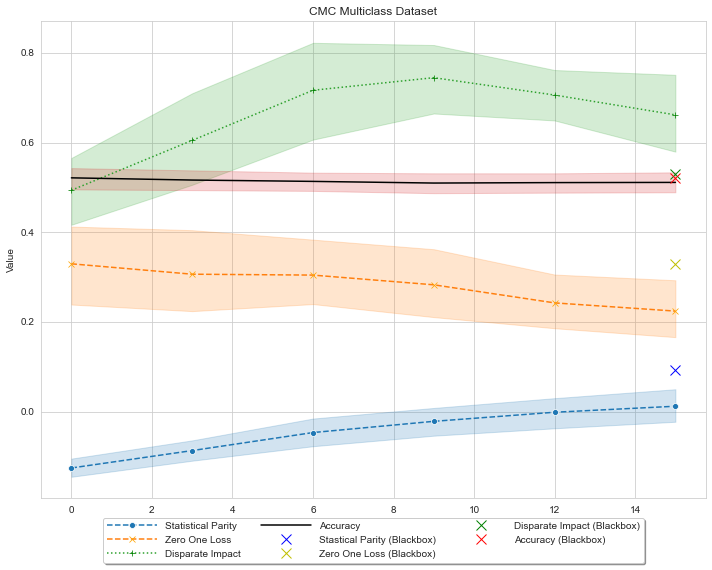

In [35]:
points = preparepoints(blackboxmetrics, demv.get_iters())
plot_metrics_curves(df, points, title='CMC Multiclass Dataset')

In [36]:
unprivpergentage(data,unpriv_group, demv.get_iters())

Dataset size: 1473
Unprivileged group size: 955
Percentage of unprivileged group: 64.8336727766463
Number of iterations: 15


In [37]:
blackboxmetrics

{'stat_par': [[-0.2071678321678322],
  [0.16715542521994134],
  [-0.008482745324850577],
  [0.08517156862745098],
  [0.15756724207145725],
  [0.3786764705882353],
  [0.13873626373626374],
  [0.04636692091529507],
  [0.09525773195876287],
  [0.06818181818181819]],
 'zero_one_loss': [[0.5862068965517242],
  [0.4340277777777778],
  [0.2777777777777778],
  [0.3307692307692308],
  [0.05555555555555558],
  [0.15714285714285714],
  [0.3508771929824561],
  [0.3563829787234043],
  [0.48750000000000004],
  [0.2597402597402597]],
 'disp_imp': [[0.49358974358974356],
  [0.3522727272727273],
  [0.9395604395604397],
  [0.6971677559912854],
  [0.4892648015614834],
  [0.13445378151260504],
  [0.4739583333333333],
  [0.7094339622641509],
  [0.4564705882352942],
  [0.5499999999999999]],
 'acc': [[0.5405405405405406],
  [0.5202702702702703],
  [0.5540540540540541],
  [0.43537414965986393],
  [0.5238095238095238],
  [0.54421768707483],
  [0.54421768707483],
  [0.48299319727891155],
  [0.5714285714285714],